In [1]:
%%time
from concurrent.futures import ThreadPoolExecutor
from pathlib import Path

import pandas as pd

label = pd.read_csv("labelamino.csv")
root = Path('csv')

with ThreadPoolExecutor() as ex:
    X = list(ex.map(lambda f: pd.read_csv(root / f)['I'].values, label['file']))
y, classes = pd.factorize(label['Label'])

pd.DataFrame({
    'X': X,
    'y': y,
    'files': label['file'],
    'labels': label['Label']
}).to_parquet('data.parquet', compression='zstd')

CPU times: user 2min 33s, sys: 22.6 s, total: 2min 55s
Wall time: 1min 52s


In [2]:
%%time
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
device = torch.device("cuda")

df = pd.read_parquet('data.parquet')
X = torch.tensor(np.vstack(df['X']), device=device, dtype=torch.float32)
y = torch.tensor(df['y'].values, device=device, dtype=torch.long)

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=42)
label_map = dict(enumerate(df['labels'].unique()))

CPU times: user 5.06 s, sys: 2.81 s, total: 7.87 s
Wall time: 5.48 s


In [3]:
label_map = dict(enumerate(df['labels'].unique()))
label_map

{0: 'Polyamine', 1: 'Diamine', 2: 'Single Amino', 3: 'none'}

Fold 1

Epoch [1/50]
  Train Accu: 72.62%
  Val Accu: 75.11%

Epoch [2/50]
  Train Accu: 77.17%
  Val Accu: 70.76%

Epoch [3/50]
  Train Accu: 79.62%
  Val Accu: 79.47%

Epoch [4/50]
  Train Accu: 81.45%
  Val Accu: 80.19%

Epoch [5/50]
  Train Accu: 82.86%
  Val Accu: 78.79%

Epoch [6/50]
  Train Accu: 83.85%
  Val Accu: 81.43%

Epoch [7/50]
  Train Accu: 85.15%
  Val Accu: 83.28%

Epoch [8/50]
  Train Accu: 86.61%
  Val Accu: 83.11%

Epoch [9/50]
  Train Accu: 87.29%
  Val Accu: 83.34%

Epoch [10/50]
  Train Accu: 88.34%
  Val Accu: 83.77%

Epoch [11/50]
  Train Accu: 89.55%
  Val Accu: 83.97%

Epoch [12/50]
  Train Accu: 90.26%
  Val Accu: 82.93%

Epoch [13/50]
  Train Accu: 90.91%
  Val Accu: 83.53%

Epoch [14/50]
  Train Accu: 92.11%
  Val Accu: 84.51%

Epoch [15/50]
  Train Accu: 92.89%
  Val Accu: 84.70%

Epoch [16/50]
  Train Accu: 93.40%
  Val Accu: 84.69%

Epoch [17/50]
  Train Accu: 94.25%
  Val Accu: 83.79%

Epoch [18/50]
  Train Accu: 94.87%
  Val Accu: 84.82%

Epoch [19/5

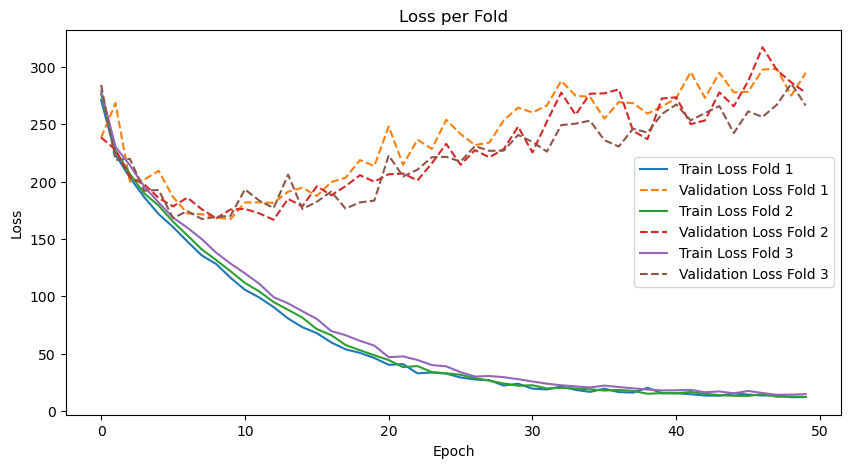

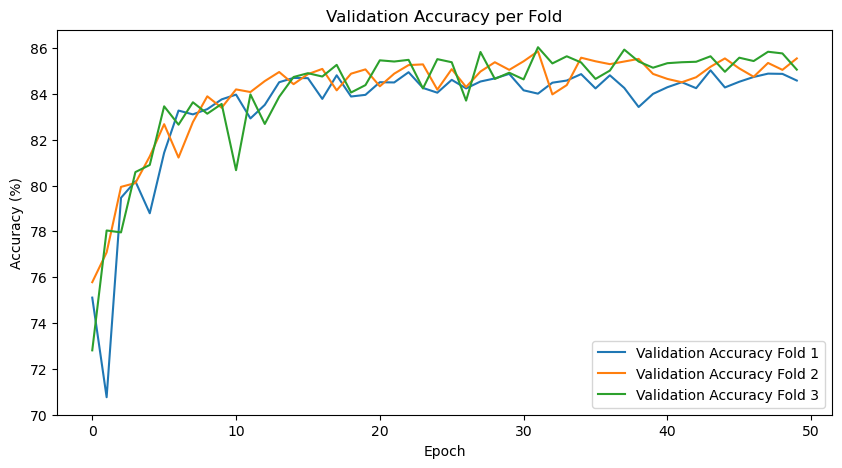

Fold 1 Test Accuracy: 84.48%
Fold 2 Test Accuracy: 84.39%
Fold 3 Test Accuracy: 84.01%
84.29597252575711


In [4]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from polyloss import Poly1CrossEntropyLoss, Poly1FocalLoss
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset


class ECA(nn.Module):

    def __init__(self, in_channel, b=1, gama=2):
        super(ECA, self).__init__()

        kernel_size = int(abs((math.log(in_channel, 2) + b) / gama))

        if kernel_size % 2 == 0:
            kernel_size += 1
        self.conv = nn.Conv1d(in_channels=in_channel,
                              out_channels=1,
                              kernel_size=kernel_size,
                              padding=kernel_size // 2,
                              bias=False)

    def forward(self, x):
        x_pool = F.adaptive_avg_pool1d(x, 1).squeeze(-1)
        x_pool = x_pool.unsqueeze(-1)
        x_pool = self.conv(x_pool)
        x_pool = torch.sigmoid(x_pool)
        x_pool = x_pool.squeeze(-1)
        x_pool = x_pool.unsqueeze(-1)
        return x * x_pool


class mymodel(nn.Module):

    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            # nn.AdaptiveAvgPool1d(450),
            nn.Conv1d(1, 32, kernel_size=15, stride=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=3, stride=3),
            nn.Conv1d(32, 64, kernel_size=13, stride=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=2, stride=2),
            nn.Conv1d(64, 128, kernel_size=11, stride=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            ECA(128),
            nn.Conv1d(128, 256, kernel_size=7, stride=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            ECA(256),
            nn.AdaptiveAvgPool1d(64),
        )
        flattened_size = 256 * 64
        self.classifier = nn.Sequential(nn.Linear(flattened_size, 1024),
                                        nn.BatchNorm1d(1024), nn.ReLU(),
                                        nn.Dropout(0.6), nn.Linear(1024, 256),
                                        nn.BatchNorm1d(256), nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(256, num_classes))

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


batch_size = 256
num_epochs = 50
k_folds = 3
best_models = []
train_losses_per_fold = []
val_losses_per_fold = []
train_accuracies_per_fold = []
val_accuracies_per_fold = []

kf = KFold(n_splits=k_folds, shuffle=True)
for fold, (train_ids, val_ids) in enumerate(kf.split(X_train)):
    best_val_loss = float('inf')
    best_model_state_dict = None
    print(f'Fold {fold + 1}')
    epoch_train_losses = []
    epoch_val_losses = []
    epoch_train_accuracies = []
    epoch_val_accuracies = []

    # 创建训练和验证数据集
    X_train_fold = X_train[train_ids]
    y_train_fold = y_train[train_ids]
    X_val_fold = X_train[val_ids]
    y_val_fold = y_train[val_ids]

    # 转换为 DataLoader
    train_fold_dataset = TensorDataset(X_train_fold, y_train_fold)
    val_fold_dataset = TensorDataset(X_val_fold, y_val_fold)
    train_fold_loader = DataLoader(dataset=train_fold_dataset,
                                   batch_size=batch_size,
                                   shuffle=True)
    val_fold_loader = DataLoader(dataset=val_fold_dataset,
                                 batch_size=batch_size,
                                 shuffle=False)

    model = mymodel().to(device)
    criterion = Poly1CrossEntropyLoss(num_classes=4,
                                      epsilon=1.0,
                                      reduction='sum')
    optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=1e-5)
    # 训练模型
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        for X_batch, y_batch in train_fold_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == y_batch).sum().item()

        # 计算平均损失和准确率
        train_loss /= len(train_fold_loader)
        train_accuracy = 100 * train_correct / len(train_fold_dataset)
        epoch_train_losses.append(train_loss)
        epoch_train_accuracies.append(train_accuracy)

        # 评价2
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_fold_loader:
                X_val_batch, y_val_batch = X_val_batch.to(
                    device), y_val_batch.to(device)
                outputs_val = model(X_val_batch)
                loss_val = criterion(outputs_val, y_val_batch)
                val_loss += loss_val.item()
                _, predicted_val = torch.max(outputs_val.data, 1)
                val_correct += (predicted_val == y_val_batch).sum().item()

        # 计算平均损失和准确率
        val_loss /= len(val_fold_loader)
        val_accuracy = 100 * val_correct / len(val_fold_dataset)
        epoch_val_losses.append(val_loss)
        epoch_val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model

        if (epoch + 1) % 1 == 0:
            print()
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'  Train Accu: {train_accuracy:.2f}%')
            print(f'  Val Accu: {val_accuracy:.2f}%')

    best_models.append(best_model)
    train_losses_per_fold.append(epoch_train_losses)
    val_losses_per_fold.append(epoch_val_losses)
    train_accuracies_per_fold.append(epoch_train_accuracies)
    val_accuracies_per_fold.append(epoch_val_accuracies)

plt.figure(figsize=(10, 5))
for fold in range(k_folds):
    plt.plot(train_losses_per_fold[fold], label=f'Train Loss Fold {fold+1}')
    plt.plot(val_losses_per_fold[fold],
             label=f'Validation Loss Fold {fold+1}',
             linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss per Fold')
plt.show()

# plt k-flod
plt.figure(figsize=(10, 5))
for fold in range(k_folds):
    plt.plot(val_accuracies_per_fold[fold],
             label=f'Validation Accuracy Fold {fold+1}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Validation Accuracy per Fold')
plt.show()

test_dataset = TensorDataset(X_test.unsqueeze(1), y_test)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False)

test_accuracys = []
for fold, model in enumerate(best_models):
    model.eval()  # 将模型设置为评估模式
    with torch.no_grad():  # 在不需要计算梯度的情况下执行以下代码
        correct_test = 0
        total_test = 0
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(
                device), y_test_batch.to(device)
            outputs_test = model(X_test_batch.squeeze(1))  # 获取模型输出
            _, predicted_test = torch.max(outputs_test, 1)  # 获取预测的类别索引
            total_test += y_test_batch.size(0)  # 累加测试样本数量
            correct_test += (predicted_test == y_test_batch).sum().item()
        test_accuracy = 100 * correct_test / total_test  # 计算测试准确率
        test_accuracys.append(test_accuracy)
        print(f'Fold {fold + 1} Test Accuracy: {test_accuracy:.2f}%')
print(sum(test_accuracys) / len(test_accuracys))

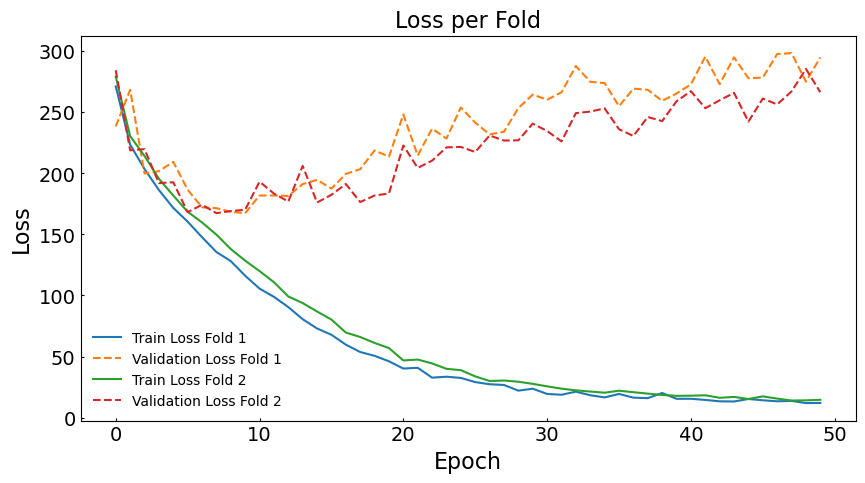

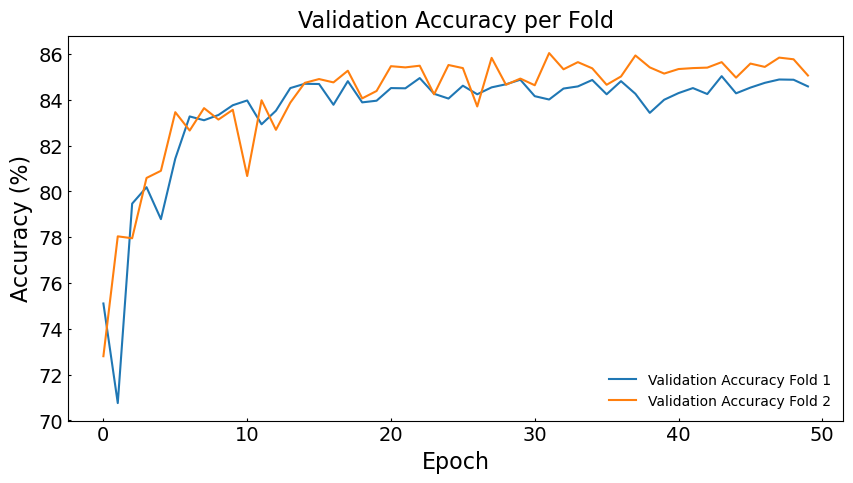

In [5]:
plt.figure(figsize=(10, 5))
fold_counter = 1  # 初始化fold计数器
for fold in range(k_folds):  # 遍历所有的fold
    if fold == 1 or fold == 3:  # 排除第1折（索引为0）和第4折（索引为3）
        continue
    plt.plot(train_losses_per_fold[fold],
             label=f'Train Loss Fold {fold_counter}')
    plt.plot(val_losses_per_fold[fold],
             label=f'Validation Loss Fold {fold_counter}',
             linestyle='--')
    fold_counter += 1  # 增加fold计数器
plt.tick_params(axis="x", direction="in", length=2, labelsize=14)
plt.tick_params(axis="y", direction="in", length=2, labelsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(frameon=False)
plt.title('Loss per Fold', fontsize=16)
# plt.savefig('picture/lossalcohola', dpi=300, bbox_inches='tight')
plt.show()
plt.figure(figsize=(10, 5))
fold_counter = 1  # 初始化fold计数器
for fold in range(k_folds):  # 遍历所有的fold
    if fold == 1 or fold == 3:  # 排除第1折（索引为0）和第4折（索引为3）
        continue
    plt.plot(val_accuracies_per_fold[fold],
             label=f'Validation Accuracy Fold {fold_counter}')
    fold_counter += 1  # 增加fold计数器
plt.tick_params(axis="x", direction="in", length=2, labelsize=14)
plt.tick_params(axis="y", direction="in", length=2, labelsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=16)
plt.legend(frameon=False)
plt.title('Validation Accuracy per Fold', fontsize=16)
# plt.savefig('picture/Accuracyamino', dpi=300, bbox_inches='tight')
plt.show()

Fold 1 Test Accuracy: 84.48%
Fold 2 Test Accuracy: 84.39%
Fold 3 Test Accuracy: 84.01%
Average: 84.30%


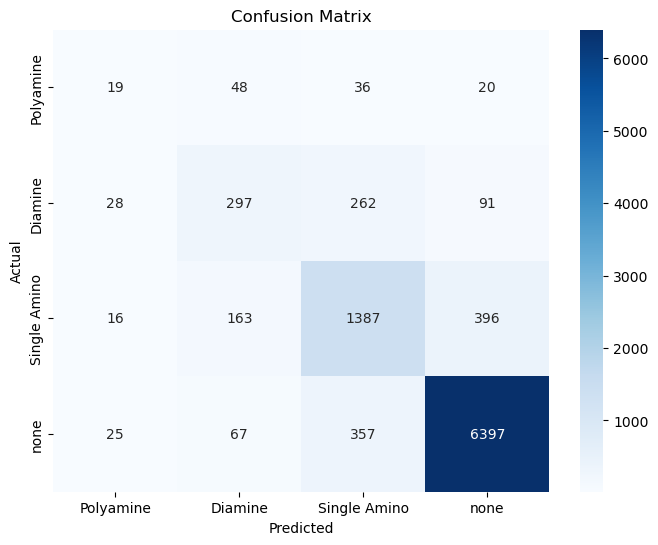

In [6]:
# 在您的代码开头添加这些导入
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 在您现有的测试循环中，将这部分：
"""
test_accuracys = []
for fold, model in enumerate(best_models):
    model.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            outputs_test = model(X_test_batch.squeeze(1))
            _, predicted_test = torch.max(outputs_test, 1)
            total_test += y_test_batch.size(0)
            correct_test += (predicted_test == y_test_batch).sum().item()
        test_accuracy = 100 * correct_test / total_test
        test_accuracys.append(test_accuracy)
        print(f'Fold {fold + 1} Test Accuracy: {test_accuracy:.2f}%')
print(sum(test_accuracys) / len(test_accuracys))
"""

# 替换为这部分：
test_accuracys = []
all_predictions = []
all_true_labels = []

for fold, model in enumerate(best_models):
    model.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        fold_pred = []
        fold_true = []

        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(
                device), y_test_batch.to(device)
            outputs_test = model(X_test_batch.squeeze(1))
            _, predicted_test = torch.max(outputs_test, 1)

            # 收集预测和真实标签
            fold_pred.extend(predicted_test.cpu().numpy())
            fold_true.extend(y_test_batch.cpu().numpy())

            total_test += y_test_batch.size(0)
            correct_test += (predicted_test == y_test_batch).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracys.append(test_accuracy)
        print(f'Fold {fold + 1} Test Accuracy: {test_accuracy:.2f}%')

        all_predictions.extend(fold_pred)
        all_true_labels.extend(fold_true)

print(f'Average: {sum(test_accuracys) / len(test_accuracys):.2f}%')

# 绘制混淆矩阵
class_names = [label_map[i] for i in range(len(label_map))]
cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Fold 1 Test Accuracy: 84.48%
Fold 2 Test Accuracy: 84.39%
Fold 3 Test Accuracy: 84.01%
Average: 84.30%


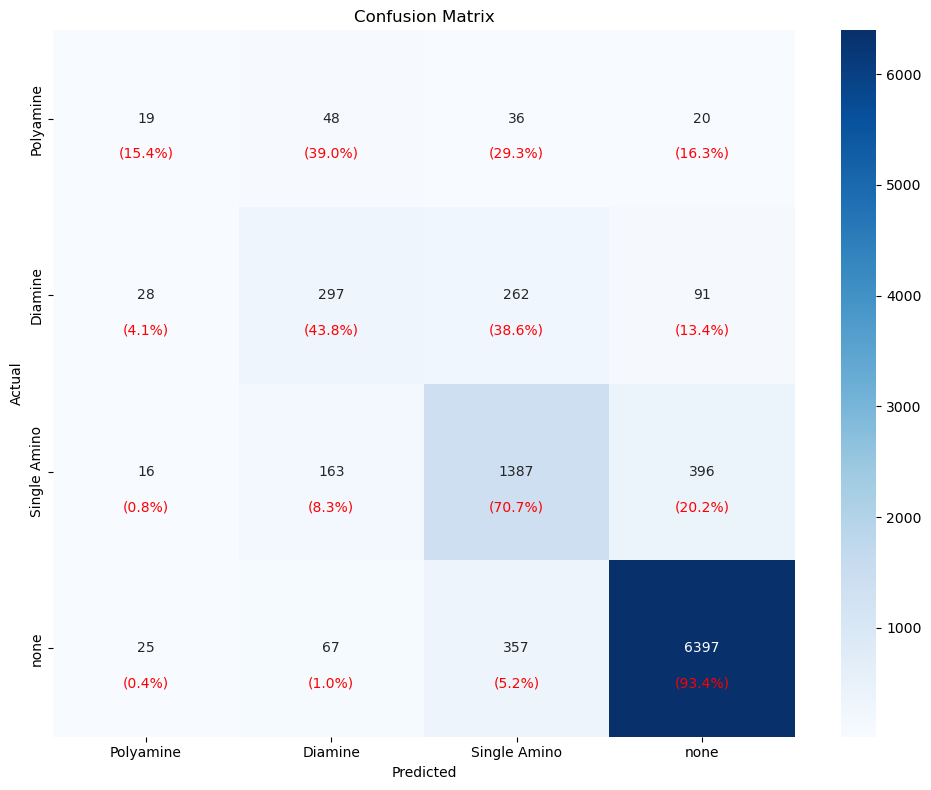


📊 详细分类报告
              precision    recall  f1-score   support

   Polyamine     0.2159    0.1545    0.1801       123
     Diamine     0.5165    0.4381    0.4741       678
Single Amino     0.6792    0.7069    0.6928      1962
        none     0.9266    0.9344    0.9305      6846

    accuracy                         0.8430      9609
   macro avg     0.5846    0.5585    0.5694      9609
weighted avg     0.8380    0.8430    0.8401      9609


📈 各类别详细指标
类别              精确率        召回率        F1分数       支持数        样本占比      
--------------------------------------------------------------------------------
Polyamine       0.2159     0.1545     0.1801     123        1.3       %
Diamine         0.5165     0.4381     0.4741     678        7.1       %
Single Amino    0.6792     0.7069     0.6928     1962       20.4      %
none            0.9266     0.9344     0.9305     6846       71.2      %
--------------------------------------------------------------------------------
宏平均             0.5846 

In [7]:
# 在您的代码开头添加这些导入
import seaborn as sns
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
)

# 替换测试部分：
test_accuracys = []
all_predictions = []
all_true_labels = []

for fold, model in enumerate(best_models):
    model.eval()
    with torch.no_grad():
        correct_test = 0
        total_test = 0
        fold_pred = []
        fold_true = []

        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(
                device), y_test_batch.to(device)
            outputs_test = model(X_test_batch.squeeze(1))
            _, predicted_test = torch.max(outputs_test, 1)

            # 收集预测和真实标签
            fold_pred.extend(predicted_test.cpu().numpy())
            fold_true.extend(y_test_batch.cpu().numpy())

            total_test += y_test_batch.size(0)
            correct_test += (predicted_test == y_test_batch).sum().item()

        test_accuracy = 100 * correct_test / total_test
        test_accuracys.append(test_accuracy)
        print(f'Fold {fold + 1} Test Accuracy: {test_accuracy:.2f}%')

        all_predictions.extend(fold_pred)
        all_true_labels.extend(fold_true)

print(f'Average: {sum(test_accuracys) / len(test_accuracys):.2f}%')

# 绘制混淆矩阵
class_names = [label_map[i] for i in range(len(label_map))]
cm = confusion_matrix(all_true_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# 在每个格子中添加百分比
for i in range(len(class_names)):
    for j in range(len(class_names)):
        total_in_class = cm[i].sum()
        percentage = cm[i,
                        j] / total_in_class * 100 if total_in_class > 0 else 0
        plt.text(j + 0.5,
                 i + 0.7,
                 f'({percentage:.1f}%)',
                 ha='center',
                 va='center',
                 fontsize=10,
                 color='red')

plt.tight_layout()
plt.show()

# 详细分类报告
print("\n" + "=" * 60)
print("📊 详细分类报告")
print("=" * 60)
report = classification_report(all_true_labels,
                               all_predictions,
                               target_names=class_names,
                               digits=4)
print(report)

# 计算并显示每个类别的详细指标
precision, recall, f1, support = precision_recall_fscore_support(
    all_true_labels, all_predictions, average=None)

print("\n" + "=" * 80)
print("📈 各类别详细指标")
print("=" * 80)
print(
    f"{'类别':<15} {'精确率':<10} {'召回率':<10} {'F1分数':<10} {'支持数':<10} {'样本占比':<10}")
print("-" * 80)

total_samples = len(all_true_labels)
for i, class_name in enumerate(class_names):
    sample_ratio = support[i] / total_samples * 100
    print(
        f"{class_name:<15} {precision[i]:<10.4f} {recall[i]:<10.4f} {f1[i]:<10.4f} {support[i]:<10} {sample_ratio:<10.1f}%"
    )

# 宏平均和加权平均
macro_precision = precision.mean()
macro_recall = recall.mean()
macro_f1 = f1.mean()

weighted_precision = np.average(precision, weights=support)
weighted_recall = np.average(recall, weights=support)
weighted_f1 = np.average(f1, weights=support)

print("-" * 80)
print(
    f"{'宏平均':<15} {macro_precision:<10.4f} {macro_recall:<10.4f} {macro_f1:<10.4f} {total_samples:<10} {'100.0%':<10}"
)
print(
    f"{'加权平均':<15} {weighted_precision:<10.4f} {weighted_recall:<10.4f} {weighted_f1:<10.4f} {total_samples:<10} {'100.0%':<10}"
)
print("=" * 80)

# 模型性能总结
overall_accuracy = sum(test_accuracys) / len(test_accuracys)
print(f"\n🎯 模型性能总结:")
print(f"   总体准确率: {overall_accuracy:.2f}%")
print(f"   宏平均F1:  {macro_f1:.4f}")
print(f"   加权平均F1: {weighted_f1:.4f}")
print(f"   测试样本数: {total_samples}")

# 找出表现最好和最差的类别
best_class_idx = np.argmax(f1)
worst_class_idx = np.argmin(f1)

print(f"\n📊 类别表现分析:")
print(f"   最佳类别: {class_names[best_class_idx]} (F1: {f1[best_class_idx]:.4f})")
print(
    f"   最差类别: {class_names[worst_class_idx]} (F1: {f1[worst_class_idx]:.4f})")

# 混淆矩阵分析
print(f"\n🔍 混淆矩阵分析:")
for i, class_name in enumerate(class_names):
    true_positive = cm[i, i]
    total_actual = cm[i].sum()
    total_predicted = cm[:, i].sum()

    if total_actual > 0:
        class_recall = true_positive / total_actual
        print(
            f"   {class_name}: {true_positive}/{total_actual} 正确识别 (召回率: {class_recall:.3f})"
        )

    # 找出主要的错误分类
    if total_actual > 0:
        wrong_predictions = [(j, cm[i, j])
                             for j in range(len(class_names))
                             if i != j and cm[i, j] > 0]
        if wrong_predictions:
            wrong_predictions.sort(key=lambda x: x[1], reverse=True)
            main_confusion = wrong_predictions[0]
            print(
                f"      主要误分类为: {class_names[main_confusion[0]]} ({main_confusion[1]}个样本)"
            )

print("\n" + "=" * 60)

In [8]:
f1


array([0.18009479, 0.47406225, 0.69280719, 0.93047273])